In [18]:
#Подключаем библиотеки
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

In [21]:
path = '../../Base/genres'
genres = os.listdir(path)

In [7]:
# Функция параметризации аудио
def get_features_2d(y, sr):

  # Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)     # Частота цветности
  rmse = librosa.feature.rms(y=y)                          # Среднеквадратичная амплитуда
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) # Спектральный центроид
  mfcc = librosa.feature.mfcc(y=y, sr=sr)                   # Мел спектральные коэффициенты
  
  # Возвращаем получившийся список
  return mfcc, chroma_stft, rmse, spec_cent

In [22]:
import time # Для подсчёта времени на обработку одного жанра

# Формируем обучающую выборку
# Создаём пустые листы
X_train_mfcc = []
X_train_chroma_stft = []
X_train_rmse = []
X_train_spec_cent = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

# Длина каждой записи первые 20 секунд
seconds = 20

# Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] # Берём текущий жанр

  # Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'{path}/{g}'):

    # Получаем имя песни
    songname = f'{path}/{g}/{filename}'

    # Загружаем в y аудиосигнал
    # Используем первые %seconds% секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=seconds)

    # Превращаем сигнал в параметризованные данные
    for sec in range(seconds):
      mfcc, chroma_stft, rmse, spec_cent = get_features_2d(y[sec*sr:(sec+1)*sr], sr)
      X_train_mfcc.append(mfcc)
      X_train_chroma_stft.append(chroma_stft)
      X_train_rmse.append(rmse)
      X_train_spec_cent.append(spec_cent)
      Y_train.append(utils.to_categorical(i, len(genres)))

  # Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

# Превращаем обучающую выборку на numpy массивы
X_train_mfcc = np.array(X_train_mfcc)
X_train_chroma_stft = np.array(X_train_chroma_stft)
X_train_rmse = np.array(X_train_rmse)
X_train_spec_cent = np.array(X_train_spec_cent)
Y_train = np.array(Y_train)

Жанр blues готов -> 28c
Жанр classical готов -> 29c
Жанр country готов -> 26c
Жанр disco готов -> 26c
Жанр hiphop готов -> 26c
Жанр jazz готов -> 27c
Жанр metal готов -> 27c
Жанр pop готов -> 27c
Жанр reggae готов -> 28c
Жанр rock готов -> 27c


In [9]:
# Решейпим данные для нейронки
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0], X_train_mfcc.shape[1], X_train_mfcc.shape[2], 1)
X_train_chroma_stft = X_train_chroma_stft.reshape(X_train_chroma_stft.shape[0], X_train_chroma_stft.shape[1], X_train_chroma_stft.shape[2], 1)
X_train_rmse = X_train_rmse.reshape(X_train_rmse.shape[0], X_train_rmse.shape[2], X_train_rmse.shape[1])
X_train_spec_cent = X_train_spec_cent.reshape(X_train_spec_cent.shape[0], X_train_spec_cent.shape[2], X_train_spec_cent.shape[1])

In [10]:
print(X_train_mfcc.shape)
print(X_train_chroma_stft.shape)
print(X_train_rmse.shape)
print(X_train_spec_cent.shape)

(20000, 20, 44, 1)
(20000, 12, 44, 1)
(20000, 44, 1)
(20000, 44, 1)


In [11]:
val_mask = np.random.sample(20000)
train_mask = val_mask < 0.9
val_mask = val_mask >= 0.9

In [12]:
# Функция нормализации
def scale(X):
  min_X = X.min()
  max_X = X.max()
  X = (X - min_X) / (max_X - min_X)
  return X

In [13]:
# Нормализация
X_train_mfcc_scaled = scale(X_train_mfcc)
X_train_chroma_stft_scaled = scale(X_train_chroma_stft)
X_train_rmse_scaled = scale(X_train_rmse)
X_train_spec_cent_scaled = scale(X_train_spec_cent)

## Создаём нейронку

In [23]:
input_mfcc = Input((20, 44, 1))        # Входной слой для mfcc
input_chroma_stft = Input((12, 44, 1)) # Входной слой для chroma_stft
input_rmse = Input((44, 1))            # Входной слой для rmse
input_spec_cent = Input((44, 1))       # Входной слой для spec_cent

# Блок mfcc
x1 = BatchNormalization()(input_mfcc)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Flatten()(x1)

# Блок chroma_stft
x2 = BatchNormalization()(input_chroma_stft)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2_gmp_1 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2_gmp_2 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2_gmp_3 = GlobalMaxPooling2D()(x2)
x2 = Flatten()(x2)

# Блок rmse
x3 = BatchNormalization()(input_rmse)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Flatten()(x3)

# Блок spec_cent
x4 = BatchNormalization()(input_spec_cent)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Flatten()(x4)

# Объедияем все блоки
x = concatenate([x1, x2, x3, x4, x2_gmp_1, x2_gmp_2, x2_gmp_3])

# Полносвязные слои на выходе
x = Dense(128, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model([input_mfcc, input_chroma_stft, input_rmse, input_spec_cent], x)

model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/50
71/71 [==============================] - 9s 105ms/step - loss: 1.3577 - accuracy: 0.5083 - val_loss: 4.5415 - val_accuracy: 0.1565
Epoch 2/50
71/71 [==============================] - 7s 99ms/step - loss: 0.9469 - accuracy: 0.6662 - val_loss: 4.3213 - val_accuracy: 0.1436
Epoch 3/50
71/71 [==============================] - 7s 98ms/step - loss: 0.7574 - accuracy: 0.7396 - val_loss: 7.6413 - val_accuracy: 0.0932
Epoch 4/50
71/71 [==============================] - 7s 99ms/step - loss: 0.6096 - accuracy: 0.7895 - val_loss: 3.6699 - val_accuracy: 0.3260
Epoch 5/50
71/71 [==============================] - 7s 99ms/step - loss: 0.4888 - accuracy: 0.8306 - val_loss: 3.2671 - val_accuracy: 0.3170
Epoch 6/50
71/71 [==============================] - 7s 98ms/step - loss: 0.3852 - accuracy: 0.8648 - val_loss: 3.4221 - val_accuracy: 0.3210
Epoch 7/50
71/71 [==============================] - 7s 98ms/step - loss: 0.2974 - accuracy: 0.8974 - val_loss: 2.4717 - val_accuracy: 0.4362
Epoch 8/50
7

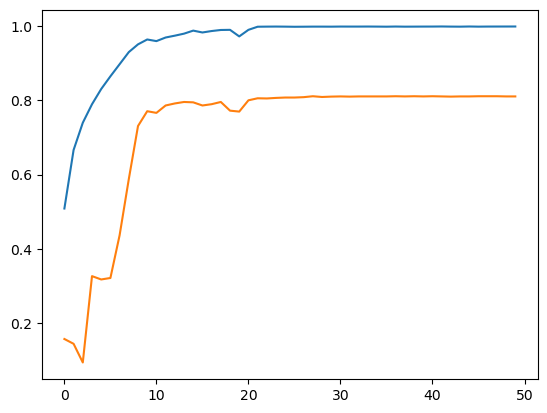

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Добавляем колбэк ReduceLROnPlateau для уменьшения шага обучения
reduce_ = ReduceLROnPlateau(monitor='val_loss')

# Обучаем модель
history = model.fit([X_train_mfcc_scaled[train_mask], X_train_chroma_stft_scaled[train_mask], X_train_rmse_scaled[train_mask], X_train_spec_cent_scaled[train_mask]],
                    Y_train[train_mask],
                    epochs=50,
                    batch_size=256,
                    validation_data=([X_train_mfcc_scaled[val_mask], X_train_chroma_stft_scaled[val_mask], X_train_rmse_scaled[val_mask], X_train_spec_cent_scaled[val_mask]],
                    Y_train[val_mask]),
                    callbacks=[reduce_])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()